In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 

In [2]:
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

## Coherence

In [29]:
# Defining get_coherence
# Modified for parliament 
def get_coherence(run_id):
    stat = RunStats.objects.get(run_id=run_id)
    K = stat.K
    
    # obtain utterances in run_id 
    uts = pm.Utterance.objects.filter(search_matches=par_search_tei)
    # obtain paragraphs from utterances in queryset  
    texts = []
    for ut in uts:
        pars = ut.paragraph_set.all()
        texts.append(" ".join([x.text for x in pars]))

    sentences = [get_sentence_g(x) for x in texts]
    model = gensim.models.Word2Vec(sentences)
    validation_measure = WithinTopicMeasure(
        ModelSimilarity(model)
    )

    term_rankings = []

    topics = Topic.objects.filter(
        run_id=run_id
    )

    for topic in topics:
        term_ranking = list(Term.objects.filter(
            topicterm__topic=topic
        ).order_by(
            '-topicterm__score'
        ).values_list('title',flat=True)[:50])
        term_rankings.append(term_ranking)

    stat.coherence = validation_measure.evaluate_rankings(
        term_rankings
    )
    stat.save()

    return

In [3]:
user1, created =  User.objects.get_or_create(username='leey', email='lee@mcc-berlin.net')
print(user1)
user1.save()

leey


In [4]:
user2, created =  User.objects.get_or_create(username='muef', email='mueller-hansen@mcc-berlin.net')
print(user2)
user2.save()

muef


In [4]:
# simple search for utterances
par_search_tei, created = pm.Search.objects.get_or_create(
                title="Kohle tei utterance",
                text="kohle",
                creator=user1,
                document_source="GermaParlTEI",
                search_object_type=2)
par_search_tei.save()
if created:
    print("doing search")
do_search(par_search_tei.id)
print(par_search_tei.par_count)
print(par_search_tei.utterance_count)
print(par_search_tei.runstats_set.all())

3281 utterances with search kohle
35275
3281
35275
3281
<QuerySet [<RunStats: RunStats object (1060)>, <RunStats: RunStats object (967)>, <RunStats: RunStats object (966)>, <RunStats: RunStats object (964)>, <RunStats: RunStats object (1045)>, <RunStats: RunStats object (1049)>, <RunStats: RunStats object (1046)>, <RunStats: RunStats object (1050)>, <RunStats: RunStats object (1047)>, <RunStats: RunStats object (1051)>, <RunStats: RunStats object (1048)>, <RunStats: RunStats object (1052)>, <RunStats: RunStats object (1053)>, <RunStats: RunStats object (1055)>, <RunStats: RunStats object (1057)>, <RunStats: RunStats object (1058)>, <RunStats: RunStats object (1059)>]>


In [5]:
Ks = [20, 30, 40, 50] 
search_word = "Kohle"

In [6]:
method="LD"
run_ids_ld = []
for K in Ks:
    run_ids_ld.append(RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K).run_id)

In [8]:
method_2="NM"
run_ids_nm = []
for K in Ks:
    run_ids_nm.append(RunStats.objects.filter(psearch__title="{} tei utterance".format(search_word), method=method_2, K=K)[0].run_id)

In [9]:
print(run_ids_ld)
print(run_ids_nm)

[1045, 1046, 1047, 1048]
[1029, 948, 1030, 1031]


In [27]:
for run_id in run_ids_ld:
    get_coherence(run_id)

In [38]:
for run_id in run_ids_nm:
    get_coherence(run_id)

## Reconstruction

### Topic Model runs with reconstruction 

In [23]:
# do search

# number of topics

In [ ]:
# Reconstruction for 1049, 1050, 1051, 1052
rec_error = [52.99340807986115, 52.467567883251675, 52.061537403294786, 51.69738379479796]

In [9]:
run_tm(par_search_tei.id, 20, method='NM')

creating term frequency-inverse document frequency matrix (5.376278400421143)
save terms to db (71.05574941635132)
running matrix factorization with NMF (120.97003960609436)
Reconstruction error of nmf: 52.98561700198638
saving document topic matrix to db (162.6812334060669)
topic model run done (169.07138061523438)


0

In [7]:
for K in Ks:
    run_tm(par_search_tei.id, K, method='LD')

creating term frequency matrix (5.174529314041138)
save terms to db (70.22257471084595)
running Latent Dirichlet Allocation (120.2374620437622)
saving document topic matrix to db (241.92612528800964)
topic model run done (253.1989984512329)
creating term frequency matrix (4.918903350830078)
save terms to db (70.76756739616394)
running Latent Dirichlet Allocation (120.34649586677551)
saving document topic matrix to db (275.44725251197815)
topic model run done (292.3270399570465)
creating term frequency matrix (5.028928518295288)
save terms to db (70.77572798728943)
running Latent Dirichlet Allocation (120.67517042160034)
saving document topic matrix to db (307.7472150325775)
topic model run done (332.18872332572937)
creating term frequency matrix (5.549048900604248)
save terms to db (70.84816074371338)
running Latent Dirichlet Allocation (120.98731064796448)
saving document topic matrix to db (354.0952191352844)
topic model run done (385.6611750125885)


## Plots

### Coherence Plots 

In [12]:
# Style
sns.set_style('whitegrid')

In [44]:
coherences_ld = []
for run_id in run_ids_ld:
    coherences_ld.append(RunStats.objects.get(run_id=run_id).coherence)
    
coherences_nm = []
for run_id in run_ids_nm:
    coherences_nm.append(RunStats.objects.get(run_id=run_id).coherence)

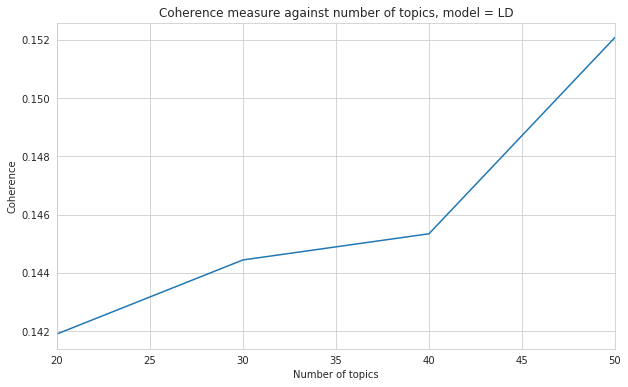

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(Ks, coherences_ld, ax = ax)
ax.set(xlim=(20,50),xlabel="Number of topics",ylabel="Coherence", title="Coherence measure against number of topics, model = {}".format(method))
plt.show()

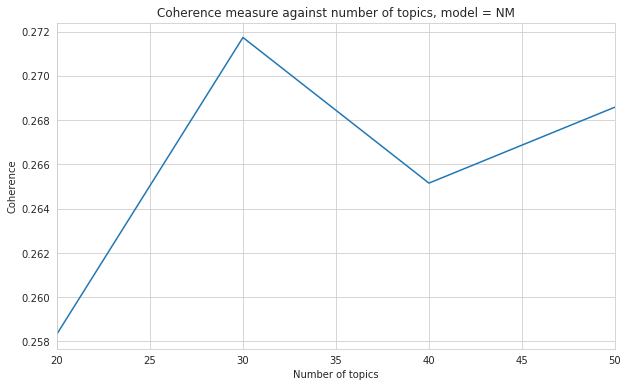

In [51]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(Ks, coherences_nm, ax = ax)
ax.set(xlim=(20,50),xlabel="Number of topics",ylabel="Coherence", title="Coherence measure against number of topics, model = {}".format(method_2))
plt.show()

In [14]:
K2 = [30,40,50]
# TM run
for i in K2:
    run_tm(par_search_tei.id, i, method='NM')

creating term frequency-inverse document frequency matrix (4.954632043838501)
save terms to db (71.12282252311707)
running matrix factorization with NMF (121.85753011703491)
Reconstruction error of nmf: 52.46614087522035
saving document topic matrix to db (178.2453532218933)
topic model run done (186.79599022865295)
creating term frequency-inverse document frequency matrix (4.966296911239624)
save terms to db (70.27073001861572)
running matrix factorization with NMF (120.1700656414032)
Reconstruction error of nmf: 52.05730843480119
saving document topic matrix to db (189.6933798789978)
topic model run done (199.88969135284424)
creating term frequency-inverse document frequency matrix (5.452517747879028)
save terms to db (70.7997555732727)
running matrix factorization with NMF (120.76042318344116)
Reconstruction error of nmf: 51.68921473346379
saving document topic matrix to db (204.86810851097107)
topic model run done (216.71289014816284)


### Reconstruction Plots

In [24]:
run_ids_nm_rec = [1055, 1057, 1058, 1059]
rec_error_nm = []
rec_error_type = []

for run_id in run_ids_nm_rec:
    rec_error_nm.append(RunStats.objects.get(run_id=run_id).error)
    rec_error_type.append(RunStats.objects.get(run_id=run_id).errortype)

print(rec_error_nm)
print(rec_error_type)

[52.9856170019864, 52.4661408752203, 52.0573084348012, 51.6892147334638]
['Frobenius', 'Frobenius', 'Frobenius', 'Frobenius']


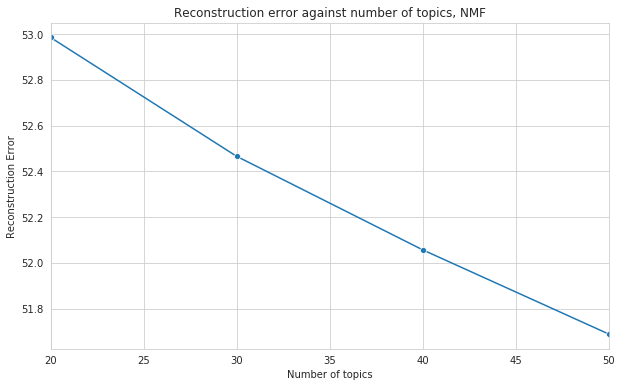

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(Ks, rec_error_nm, ax = ax, marker='o')
ax.set(xlim=(20,50),xlabel="Number of topics",ylabel="Reconstruction Error", title="Reconstruction error against number of topics, NMF")
plt.show()

In [11]:
run_ids_ld_err = [1061,1062,1063,1064]
error_ld = []
error_type_ld = []

for run_id in run_ids_ld_err:
    error_ld.append(RunStats.objects.get(run_id=run_id).error)
    error_type_ld.append(RunStats.objects.get(run_id=run_id).error)
    
print(error_ld)    

[5426.96184161511, 7938.29180776891, 11664.1677990161, 17120.0910748694]


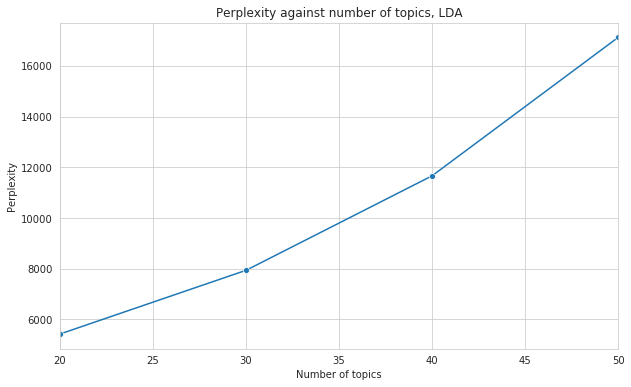

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(Ks, error_ld, ax = ax, marker='o')
ax.set(xlim=(20,50),xlabel="Number of topics",ylabel="Perplexity", title="Perplexity against number of topics, LDA")
plt.show()